### 作業目的: 實作word2vec Skip-gram模型
在課程中了解如何搭建CBOW模型，這次的作業目的在於透過搭建Skip-gram模型來了解另外一種word2vec的架構。

Hint_1: 學員可以善用課程中以搭建好的function模組
Hint_2: Skip_gram所需的輸入資料與目標跟CBOW有些許不同，Skip_gram是由中間字詞預測上下文

In [1]:
# import modules
import numpy as np
from typing import List
from utils.utility import clip_grads, convert_one_hot, preprocess, Trainer
from utils.layers import Dense, SoftmaxWithCrossEntropy
from utils.optimizer import SGD

In [2]:
# use the same corpus as in the lecture
text = "I am studying Natural Language Processing now."

# define create_contexts_target function
def create_contexts_target(corpus: List, window_size: int=1):

    contexts = corpus[window_size:-window_size]
    targets = []

    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                # skip target word itself
                continue
            cs.append(corpus[idx + t])
        targets.append(cs)

    return np.array(contexts), np.array(targets)

# transform corpus to contexts and targets pair
corpus, word2idx, idx2word = preprocess([text])
contexts, targets = create_contexts_target(corpus[0], window_size=1)
contexts, targets

(array([2, 4, 7, 0, 5, 3]), array([[1, 4],
        [2, 7],
        [4, 0],
        [7, 5],
        [0, 3],
        [5, 6]]))

In [3]:
# transform contexts and targets to one-hot encoding
contexts = convert_one_hot(contexts, len(word2idx))
targets = convert_one_hot(targets, len(word2idx))
contexts, targets

(array([[0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0]]), array([[[0, 1, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 0]],
 
        [[0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1]],
 
        [[0, 0, 0, 0, 1, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 0]],
 
        [[0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 1, 0, 0]],
 
        [[1, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0, 0]],
 
        [[0, 0, 0, 0, 0, 1, 0, 0],
         [0, 0, 0, 0, 0, 0, 1, 0]]]))

In [4]:
# define Skip-gram model
class SkipGram:
    def __init__(self, vocab_size, hidden_size, window_size):
        V, H = vocab_size, hidden_size
        self.window_size = window_size

        # initialize weights
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')
        
        # create layers
        self.in_layer = Dense(W_in)
        self.out_layer = Dense(W_out)
        self.loss_layers = [SoftmaxWithCrossEntropy() for i in range(window_size * 2)]
        

        layers = [self.in_layer, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
        # word vector matrix
        self.word_vecs = W_in

    def forward(self, contexts, targets):
        h = self.in_layer.forward(contexts)
        s = self.out_layer.forward(h)
        
        loss = sum([self.loss_layers[i].forward(s, targets[:, i]) for i in range(self.window_size * 2)])
        return loss

    def backward(self, dout=1):
        
        ds = sum([self.loss_layers[i].backward(dout) for i in range(self.window_size * 2)])
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)
        
        return None

In [5]:
# start training

# configurations
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

# define model
skip_gram = SkipGram(len(word2idx), hidden_size, window_size)
sgd_optimizer = SGD()
trainer = Trainer(skip_gram, sgd_optimizer)

# start training
trainer.fit(contexts, targets, max_epoch, batch_size)

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Epoch: 1, Iteration: 1/2, Loss: 4.159054351067146
Epoch: 2, Iteration: 1/2, Loss: 4.1590113672916775
Epoch: 3, Iteration: 1/2, Loss: 4.1589031845147515
Epoch: 4, Iteration: 1/2, Loss: 4.158787662174871
Epoch: 5, Iteration: 1/2, Loss: 4.1588774201786745
Epoch: 6, Iteration: 1/2, Loss: 4.158671770734895
Epoch: 7, Iteration: 1/2, Loss: 4.158561976970741
Epoch: 8, Iteration: 1/2, Loss: 4.158476234344407
Epoch: 9, Iteration: 1/2, Loss: 4.15861563339112
Epoch: 10, Iteration: 1/2, Loss: 4.158308633786493
Epoch: 11, Iteration: 1/2, Loss: 4.158493528175848
Epoch: 12, Iteration: 1/2, Loss: 4.157964986298295
Epoch: 13, Iteration: 1/2, Loss: 4.158418928807315
Epoch: 14, Iteration: 1/2, Loss: 4.157760726223379
Epoch: 15, Iteration: 1/2, Loss: 4.158165685369991
Epoch: 16, Iteration: 1/2, Loss: 4.15780633089946
Epoch: 17, Iteration: 1/2, Loss: 4.157629776463195
Epoch: 18, Iteration: 1/2, Loss: 4.157060349030793


  2%|█▍                                                                             | 18/1000 [00:00<00:05, 179.24it/s]

Epoch: 19, Iteration: 1/2, Loss: 4.1579327823793975
Epoch: 20, Iteration: 1/2, Loss: 4.157071627673398
Epoch: 21, Iteration: 1/2, Loss: 4.1568178744185005
Epoch: 22, Iteration: 1/2, Loss: 4.156274857999994
Epoch: 23, Iteration: 1/2, Loss: 4.15692133305883
Epoch: 24, Iteration: 1/2, Loss: 4.156602571703283
Epoch: 25, Iteration: 1/2, Loss: 4.156000456663927
Epoch: 26, Iteration: 1/2, Loss: 4.156222538829679
Epoch: 27, Iteration: 1/2, Loss: 4.154586601109952
Epoch: 28, Iteration: 1/2, Loss: 4.15448294012892
Epoch: 29, Iteration: 1/2, Loss: 4.1557730938963555
Epoch: 30, Iteration: 1/2, Loss: 4.1533181898175116
Epoch: 31, Iteration: 1/2, Loss: 4.154036644318722
Epoch: 32, Iteration: 1/2, Loss: 4.151620028969487
Epoch: 33, Iteration: 1/2, Loss: 4.152280784184548
Epoch: 34, Iteration: 1/2, Loss: 4.151401499138622
Epoch: 35, Iteration: 1/2, Loss: 4.1498980637209355
Epoch: 36, Iteration: 1/2, Loss: 4.149090364447832
Epoch: 37, Iteration: 1/2, Loss: 4.148998051829107
Epoch: 38, Iteration: 1/2, L

  6%|████▊                                                                          | 61/1000 [00:00<00:04, 216.68it/s]

Epoch: 62, Iteration: 1/2, Loss: 4.020336931300561
Epoch: 63, Iteration: 1/2, Loss: 3.987106886119637
Epoch: 64, Iteration: 1/2, Loss: 3.9729091575560544
Epoch: 65, Iteration: 1/2, Loss: 3.991168481232937
Epoch: 66, Iteration: 1/2, Loss: 3.886592374233002
Epoch: 67, Iteration: 1/2, Loss: 3.9073560281759274
Epoch: 68, Iteration: 1/2, Loss: 3.8425697030126846
Epoch: 69, Iteration: 1/2, Loss: 3.906144389055645
Epoch: 70, Iteration: 1/2, Loss: 3.8573119537863247
Epoch: 71, Iteration: 1/2, Loss: 3.7554179748514134
Epoch: 72, Iteration: 1/2, Loss: 3.756405899201283
Epoch: 73, Iteration: 1/2, Loss: 3.713673066436768
Epoch: 74, Iteration: 1/2, Loss: 3.6754353925801393
Epoch: 75, Iteration: 1/2, Loss: 3.5826956868010558
Epoch: 76, Iteration: 1/2, Loss: 3.6338017716120654
Epoch: 77, Iteration: 1/2, Loss: 3.4969162910995477
Epoch: 78, Iteration: 1/2, Loss: 3.4435518253040005
Epoch: 79, Iteration: 1/2, Loss: 3.4398826148181145
Epoch: 80, Iteration: 1/2, Loss: 3.457840067911354
Epoch: 81, Iteration

 10%|███████▉                                                                      | 101/1000 [00:00<00:03, 250.87it/s]

Epoch: 102, Iteration: 1/2, Loss: 2.4637813629713845
Epoch: 103, Iteration: 1/2, Loss: 2.4249910981718923
Epoch: 104, Iteration: 1/2, Loss: 2.441190115710299
Epoch: 105, Iteration: 1/2, Loss: 2.211908286912582
Epoch: 106, Iteration: 1/2, Loss: 2.382453839361103
Epoch: 107, Iteration: 1/2, Loss: 2.3621693059322935
Epoch: 108, Iteration: 1/2, Loss: 2.2198173162952353
Epoch: 109, Iteration: 1/2, Loss: 2.2084973639208947
Epoch: 110, Iteration: 1/2, Loss: 2.1793411577096125
Epoch: 111, Iteration: 1/2, Loss: 2.2330386105658984
Epoch: 112, Iteration: 1/2, Loss: 2.1495465056120713
Epoch: 113, Iteration: 1/2, Loss: 2.0577689930976364
Epoch: 114, Iteration: 1/2, Loss: 2.1289296345454214
Epoch: 115, Iteration: 1/2, Loss: 2.1001806894461175
Epoch: 116, Iteration: 1/2, Loss: 1.9540649223211797
Epoch: 117, Iteration: 1/2, Loss: 2.1024418146852675
Epoch: 118, Iteration: 1/2, Loss: 1.9124526509515696
Epoch: 119, Iteration: 1/2, Loss: 1.9838481000527204
Epoch: 120, Iteration: 1/2, Loss: 1.9786537378443

 15%|███████████▍                                                                  | 146/1000 [00:00<00:02, 288.87it/s]

Epoch: 147, Iteration: 1/2, Loss: 1.6116534643745246
Epoch: 148, Iteration: 1/2, Loss: 1.5918808321845979
Epoch: 149, Iteration: 1/2, Loss: 1.5990964696069552
Epoch: 150, Iteration: 1/2, Loss: 1.5922707217189886
Epoch: 151, Iteration: 1/2, Loss: 1.5620252915279758
Epoch: 152, Iteration: 1/2, Loss: 1.5784338205450799
Epoch: 153, Iteration: 1/2, Loss: 1.568170770106359
Epoch: 154, Iteration: 1/2, Loss: 1.564471554340771
Epoch: 155, Iteration: 1/2, Loss: 1.5620835635729797
Epoch: 156, Iteration: 1/2, Loss: 1.5522968268576103
Epoch: 157, Iteration: 1/2, Loss: 1.5527583910779716
Epoch: 158, Iteration: 1/2, Loss: 1.5553468815547051
Epoch: 159, Iteration: 1/2, Loss: 1.5223006640796242
Epoch: 160, Iteration: 1/2, Loss: 1.5511931547820894
Epoch: 161, Iteration: 1/2, Loss: 1.536906744271461
Epoch: 162, Iteration: 1/2, Loss: 1.5202498079515934
Epoch: 163, Iteration: 1/2, Loss: 1.5493295155464422
Epoch: 164, Iteration: 1/2, Loss: 1.5154547670116316
Epoch: 165, Iteration: 1/2, Loss: 1.5074504172588

 19%|██████████████▉                                                               | 192/1000 [00:00<00:02, 323.97it/s]

Epoch: 193, Iteration: 1/2, Loss: 1.4712053718934863
Epoch: 194, Iteration: 1/2, Loss: 1.4584807521303538
Epoch: 195, Iteration: 1/2, Loss: 1.4691479231196531
Epoch: 196, Iteration: 1/2, Loss: 1.4557133239143214
Epoch: 197, Iteration: 1/2, Loss: 1.4545055109113239
Epoch: 198, Iteration: 1/2, Loss: 1.465496129620723
Epoch: 199, Iteration: 1/2, Loss: 1.4584004148225633
Epoch: 200, Iteration: 1/2, Loss: 1.4577647169945982
Epoch: 201, Iteration: 1/2, Loss: 1.455916808879642
Epoch: 202, Iteration: 1/2, Loss: 1.4555969234525366
Epoch: 203, Iteration: 1/2, Loss: 1.453472657354309
Epoch: 204, Iteration: 1/2, Loss: 1.4536173266035277
Epoch: 205, Iteration: 1/2, Loss: 1.4530431627658769
Epoch: 206, Iteration: 1/2, Loss: 1.4462456174963996
Epoch: 207, Iteration: 1/2, Loss: 1.459955621220763
Epoch: 208, Iteration: 1/2, Loss: 1.4489298378333737
Epoch: 209, Iteration: 1/2, Loss: 1.444514682969535
Epoch: 210, Iteration: 1/2, Loss: 1.4478663263135285
Epoch: 211, Iteration: 1/2, Loss: 1.446792128277904

 24%|██████████████████▉                                                           | 242/1000 [00:00<00:02, 361.65it/s]

Epoch: 243, Iteration: 1/2, Loss: 1.4312313423088234
Epoch: 244, Iteration: 1/2, Loss: 1.4272987643791972
Epoch: 245, Iteration: 1/2, Loss: 1.4304812797367013
Epoch: 246, Iteration: 1/2, Loss: 1.4212543252755228
Epoch: 247, Iteration: 1/2, Loss: 1.4292413921600187
Epoch: 248, Iteration: 1/2, Loss: 1.426087859721743
Epoch: 249, Iteration: 1/2, Loss: 1.4257391361725689
Epoch: 250, Iteration: 1/2, Loss: 1.4279355224992616
Epoch: 251, Iteration: 1/2, Loss: 1.4249607984989763
Epoch: 252, Iteration: 1/2, Loss: 1.4195074773534428
Epoch: 253, Iteration: 1/2, Loss: 1.4294824275052682
Epoch: 254, Iteration: 1/2, Loss: 1.4211858186500808
Epoch: 255, Iteration: 1/2, Loss: 1.426000571351703
Epoch: 256, Iteration: 1/2, Loss: 1.4186885310849044
Epoch: 257, Iteration: 1/2, Loss: 1.4226813246022676
Epoch: 258, Iteration: 1/2, Loss: 1.4247540560208347
Epoch: 259, Iteration: 1/2, Loss: 1.4221653995794719
Epoch: 260, Iteration: 1/2, Loss: 1.4199180604495976
Epoch: 261, Iteration: 1/2, Loss: 1.423677060922

 29%|██████████████████████▊                                                       | 292/1000 [00:00<00:01, 392.79it/s]

Epoch: 293, Iteration: 1/2, Loss: 1.4150326418224541
Epoch: 294, Iteration: 1/2, Loss: 1.4133004967361864
Epoch: 295, Iteration: 1/2, Loss: 1.413412271018689
Epoch: 296, Iteration: 1/2, Loss: 1.4126369790925173
Epoch: 297, Iteration: 1/2, Loss: 1.4112524509419995
Epoch: 298, Iteration: 1/2, Loss: 1.4140383594054693
Epoch: 299, Iteration: 1/2, Loss: 1.4140833059725375
Epoch: 300, Iteration: 1/2, Loss: 1.4120191207933677
Epoch: 301, Iteration: 1/2, Loss: 1.4121379727332464
Epoch: 302, Iteration: 1/2, Loss: 1.4102526939833788
Epoch: 303, Iteration: 1/2, Loss: 1.4131810255752517
Epoch: 304, Iteration: 1/2, Loss: 1.4085657534177844
Epoch: 305, Iteration: 1/2, Loss: 1.4128180464247868
Epoch: 306, Iteration: 1/2, Loss: 1.4094565290625711
Epoch: 307, Iteration: 1/2, Loss: 1.412595530643961
Epoch: 308, Iteration: 1/2, Loss: 1.4105276920047374
Epoch: 309, Iteration: 1/2, Loss: 1.4108821880772986
Epoch: 310, Iteration: 1/2, Loss: 1.4103110691368337
Epoch: 311, Iteration: 1/2, Loss: 1.409019619697

 34%|██████████████████████████▌                                                   | 340/1000 [00:00<00:01, 413.57it/s]

Epoch: 341, Iteration: 1/2, Loss: 1.405100959672326
Epoch: 342, Iteration: 1/2, Loss: 1.4074797492018751
Epoch: 343, Iteration: 1/2, Loss: 1.4048743629571727
Epoch: 344, Iteration: 1/2, Loss: 1.4046696493169009
Epoch: 345, Iteration: 1/2, Loss: 1.4079368608551293
Epoch: 346, Iteration: 1/2, Loss: 1.4057976134453625
Epoch: 347, Iteration: 1/2, Loss: 1.403331357657732
Epoch: 348, Iteration: 1/2, Loss: 1.4064693618655997
Epoch: 349, Iteration: 1/2, Loss: 1.406686859543341
Epoch: 350, Iteration: 1/2, Loss: 1.4039467837941815
Epoch: 351, Iteration: 1/2, Loss: 1.4041963199915202
Epoch: 352, Iteration: 1/2, Loss: 1.4062178594868309
Epoch: 353, Iteration: 1/2, Loss: 1.4049447655304197
Epoch: 354, Iteration: 1/2, Loss: 1.4046280077226307
Epoch: 355, Iteration: 1/2, Loss: 1.4048675757132094
Epoch: 356, Iteration: 1/2, Loss: 1.4045377398202652
Epoch: 357, Iteration: 1/2, Loss: 1.4057105642074594
Epoch: 358, Iteration: 1/2, Loss: 1.40329619017918
Epoch: 359, Iteration: 1/2, Loss: 1.404385335910746

 38%|█████████████████████████████▉                                                | 384/1000 [00:00<00:01, 412.04it/s]

Epoch: 385, Iteration: 1/2, Loss: 1.4029291178179104
Epoch: 386, Iteration: 1/2, Loss: 1.4011977082632965
Epoch: 387, Iteration: 1/2, Loss: 1.4028573207697481
Epoch: 388, Iteration: 1/2, Loss: 1.4011135624761353
Epoch: 389, Iteration: 1/2, Loss: 1.4018474855705383
Epoch: 390, Iteration: 1/2, Loss: 1.4010122110597691
Epoch: 391, Iteration: 1/2, Loss: 1.4032576013174816
Epoch: 392, Iteration: 1/2, Loss: 1.4008409249464553
Epoch: 393, Iteration: 1/2, Loss: 1.4023965127599385
Epoch: 394, Iteration: 1/2, Loss: 1.4007416990656218
Epoch: 395, Iteration: 1/2, Loss: 1.4014487029105034
Epoch: 396, Iteration: 1/2, Loss: 1.4004414011923236
Epoch: 397, Iteration: 1/2, Loss: 1.4020711162874195
Epoch: 398, Iteration: 1/2, Loss: 1.4011713843115006
Epoch: 399, Iteration: 1/2, Loss: 1.401224068396466
Epoch: 400, Iteration: 1/2, Loss: 1.4019671152304887
Epoch: 401, Iteration: 1/2, Loss: 1.4009325897143334
Epoch: 402, Iteration: 1/2, Loss: 1.4001413481815566
Epoch: 403, Iteration: 1/2, Loss: 1.40158999008

 43%|█████████████████████████████████▊                                            | 434/1000 [00:01<00:01, 434.17it/s]

Epoch: 435, Iteration: 1/2, Loss: 1.399790816278304
Epoch: 436, Iteration: 1/2, Loss: 1.3981863799294283
Epoch: 437, Iteration: 1/2, Loss: 1.3991284692332675
Epoch: 438, Iteration: 1/2, Loss: 1.3994057735397116
Epoch: 439, Iteration: 1/2, Loss: 1.39823900383787
Epoch: 440, Iteration: 1/2, Loss: 1.3995241123636746
Epoch: 441, Iteration: 1/2, Loss: 1.3986225351239026
Epoch: 442, Iteration: 1/2, Loss: 1.3980102596975639
Epoch: 443, Iteration: 1/2, Loss: 1.3992868164722343
Epoch: 444, Iteration: 1/2, Loss: 1.3979504128698759
Epoch: 445, Iteration: 1/2, Loss: 1.3978529142846299
Epoch: 446, Iteration: 1/2, Loss: 1.3985672247906415
Epoch: 447, Iteration: 1/2, Loss: 1.3991062705389907
Epoch: 448, Iteration: 1/2, Loss: 1.3984679272106835
Epoch: 449, Iteration: 1/2, Loss: 1.3989194726365637
Epoch: 450, Iteration: 1/2, Loss: 1.3984232966165033
Epoch: 451, Iteration: 1/2, Loss: 1.3968922456014918
Epoch: 452, Iteration: 1/2, Loss: 1.3987808396887633
Epoch: 453, Iteration: 1/2, Loss: 1.3982299410231

 48%|█████████████████████████████████████▌                                        | 482/1000 [00:01<00:01, 428.20it/s]

Epoch: 483, Iteration: 1/2, Loss: 1.3970335444843196
Epoch: 484, Iteration: 1/2, Loss: 1.3974501531634007
Epoch: 485, Iteration: 1/2, Loss: 1.3969393097957976
Epoch: 486, Iteration: 1/2, Loss: 1.3967211937060662
Epoch: 487, Iteration: 1/2, Loss: 1.395744897191729
Epoch: 488, Iteration: 1/2, Loss: 1.396827202238131
Epoch: 489, Iteration: 1/2, Loss: 1.3973394057458361
Epoch: 490, Iteration: 1/2, Loss: 1.3965366227872105
Epoch: 491, Iteration: 1/2, Loss: 1.396138235125451
Epoch: 492, Iteration: 1/2, Loss: 1.3977548402212205
Epoch: 493, Iteration: 1/2, Loss: 1.3960552148059369
Epoch: 494, Iteration: 1/2, Loss: 1.39668532533087
Epoch: 495, Iteration: 1/2, Loss: 1.3964810843914202
Epoch: 496, Iteration: 1/2, Loss: 1.396479685037768
Epoch: 497, Iteration: 1/2, Loss: 1.3969247816505275
Epoch: 498, Iteration: 1/2, Loss: 1.3964286257812204
Epoch: 499, Iteration: 1/2, Loss: 1.3958804280176464
Epoch: 500, Iteration: 1/2, Loss: 1.3964805071719444
Epoch: 501, Iteration: 1/2, Loss: 1.3967196674127131

 53%|█████████████████████████████████████████▏                                    | 528/1000 [00:01<00:01, 436.36it/s]

Epoch: 529, Iteration: 1/2, Loss: 1.3944019807570618
Epoch: 530, Iteration: 1/2, Loss: 1.39555024501415
Epoch: 531, Iteration: 1/2, Loss: 1.3957824021315632
Epoch: 532, Iteration: 1/2, Loss: 1.3954873821407734
Epoch: 533, Iteration: 1/2, Loss: 1.3952721135189088
Epoch: 534, Iteration: 1/2, Loss: 1.3954320982252093
Epoch: 535, Iteration: 1/2, Loss: 1.3957121717413652
Epoch: 536, Iteration: 1/2, Loss: 1.3948993806456123
Epoch: 537, Iteration: 1/2, Loss: 1.3952078954980496
Epoch: 538, Iteration: 1/2, Loss: 1.394775336219197
Epoch: 539, Iteration: 1/2, Loss: 1.3955977860592115
Epoch: 540, Iteration: 1/2, Loss: 1.3951779401354123
Epoch: 541, Iteration: 1/2, Loss: 1.3947631168209877
Epoch: 542, Iteration: 1/2, Loss: 1.3951756533280721
Epoch: 543, Iteration: 1/2, Loss: 1.3955010931567358
Epoch: 544, Iteration: 1/2, Loss: 1.3945792520840752
Epoch: 545, Iteration: 1/2, Loss: 1.3955803999097407
Epoch: 546, Iteration: 1/2, Loss: 1.395079763758564
Epoch: 547, Iteration: 1/2, Loss: 1.39494390095018

 58%|████████████████████████████████████████████▉                                 | 576/1000 [00:01<00:00, 447.68it/s]

Epoch: 577, Iteration: 1/2, Loss: 1.3942868418763474
Epoch: 578, Iteration: 1/2, Loss: 1.394175063915222
Epoch: 579, Iteration: 1/2, Loss: 1.3946329077187447
Epoch: 580, Iteration: 1/2, Loss: 1.39388178795224
Epoch: 581, Iteration: 1/2, Loss: 1.39416052131173
Epoch: 582, Iteration: 1/2, Loss: 1.3942298633698633
Epoch: 583, Iteration: 1/2, Loss: 1.3936880112402448
Epoch: 584, Iteration: 1/2, Loss: 1.3950471637906623
Epoch: 585, Iteration: 1/2, Loss: 1.3936909032587808
Epoch: 586, Iteration: 1/2, Loss: 1.394483290794044
Epoch: 587, Iteration: 1/2, Loss: 1.3936032229605222
Epoch: 588, Iteration: 1/2, Loss: 1.3937688610084356
Epoch: 589, Iteration: 1/2, Loss: 1.3939925618503488
Epoch: 590, Iteration: 1/2, Loss: 1.3944423304916327
Epoch: 591, Iteration: 1/2, Loss: 1.3940461556029593
Epoch: 592, Iteration: 1/2, Loss: 1.3935509595603763
Epoch: 593, Iteration: 1/2, Loss: 1.3943300333699336
Epoch: 594, Iteration: 1/2, Loss: 1.3939872304235505
Epoch: 595, Iteration: 1/2, Loss: 1.393775729774113


 62%|████████████████████████████████████████████████▌                             | 622/1000 [00:01<00:00, 433.82it/s]

Epoch: 623, Iteration: 1/2, Loss: 1.3937803029582692
Epoch: 624, Iteration: 1/2, Loss: 1.3933780149764652
Epoch: 625, Iteration: 1/2, Loss: 1.3933125541955438
Epoch: 626, Iteration: 1/2, Loss: 1.393301227670824
Epoch: 627, Iteration: 1/2, Loss: 1.3933562332521778
Epoch: 628, Iteration: 1/2, Loss: 1.3936056429149195
Epoch: 629, Iteration: 1/2, Loss: 1.3933341942229025
Epoch: 630, Iteration: 1/2, Loss: 1.3932244344997962
Epoch: 631, Iteration: 1/2, Loss: 1.3925855780554635
Epoch: 632, Iteration: 1/2, Loss: 1.3936641340903364
Epoch: 633, Iteration: 1/2, Loss: 1.3931330508225543
Epoch: 634, Iteration: 1/2, Loss: 1.393581961172217
Epoch: 635, Iteration: 1/2, Loss: 1.3928499579347857
Epoch: 636, Iteration: 1/2, Loss: 1.3931335018951407
Epoch: 637, Iteration: 1/2, Loss: 1.393157970451755
Epoch: 638, Iteration: 1/2, Loss: 1.392768036854739
Epoch: 639, Iteration: 1/2, Loss: 1.393531113237553
Epoch: 640, Iteration: 1/2, Loss: 1.3927826697184065
Epoch: 641, Iteration: 1/2, Loss: 1.393333461337091

 67%|████████████████████████████████████████████████████▎                         | 670/1000 [00:01<00:00, 445.80it/s]

Epoch: 671, Iteration: 1/2, Loss: 1.3926001402737813
Epoch: 672, Iteration: 1/2, Loss: 1.3927024976686075
Epoch: 673, Iteration: 1/2, Loss: 1.3925289576146254
Epoch: 674, Iteration: 1/2, Loss: 1.3925926320499515
Epoch: 675, Iteration: 1/2, Loss: 1.3923188256529464
Epoch: 676, Iteration: 1/2, Loss: 1.3931186957563604
Epoch: 677, Iteration: 1/2, Loss: 1.3925514135537589
Epoch: 678, Iteration: 1/2, Loss: 1.3922440291509917
Epoch: 679, Iteration: 1/2, Loss: 1.3922683432011116
Epoch: 680, Iteration: 1/2, Loss: 1.3928435329096958
Epoch: 681, Iteration: 1/2, Loss: 1.3924555866803314
Epoch: 682, Iteration: 1/2, Loss: 1.3921925433676576
Epoch: 683, Iteration: 1/2, Loss: 1.3927575167865978
Epoch: 684, Iteration: 1/2, Loss: 1.3923784952411844
Epoch: 685, Iteration: 1/2, Loss: 1.3924847665013806
Epoch: 686, Iteration: 1/2, Loss: 1.3921350735377809
Epoch: 687, Iteration: 1/2, Loss: 1.3927116622358628
Epoch: 688, Iteration: 1/2, Loss: 1.39235964704727
Epoch: 689, Iteration: 1/2, Loss: 1.392388897707

 72%|████████████████████████████████████████████████████████                      | 719/1000 [00:01<00:00, 457.26it/s]

Epoch: 720, Iteration: 1/2, Loss: 1.3923056145470807
Epoch: 721, Iteration: 1/2, Loss: 1.3917212192479786
Epoch: 722, Iteration: 1/2, Loss: 1.3919471278892876
Epoch: 723, Iteration: 1/2, Loss: 1.3919657428146976
Epoch: 724, Iteration: 1/2, Loss: 1.3920292783170987
Epoch: 725, Iteration: 1/2, Loss: 1.3918350346092572
Epoch: 726, Iteration: 1/2, Loss: 1.3920024448501747
Epoch: 727, Iteration: 1/2, Loss: 1.3918942901819835
Epoch: 728, Iteration: 1/2, Loss: 1.3922079549505617
Epoch: 729, Iteration: 1/2, Loss: 1.3919304321471646
Epoch: 730, Iteration: 1/2, Loss: 1.3915907790374948
Epoch: 731, Iteration: 1/2, Loss: 1.3921419480207713
Epoch: 732, Iteration: 1/2, Loss: 1.391599881033707
Epoch: 733, Iteration: 1/2, Loss: 1.3921192568337801
Epoch: 734, Iteration: 1/2, Loss: 1.3912842792829965
Epoch: 735, Iteration: 1/2, Loss: 1.392421614014331
Epoch: 736, Iteration: 1/2, Loss: 1.391457866529449
Epoch: 737, Iteration: 1/2, Loss: 1.3916269616504708
Epoch: 738, Iteration: 1/2, Loss: 1.3917987774640

 77%|███████████████████████████████████████████████████████████▋                  | 766/1000 [00:01<00:00, 429.81it/s]

Epoch: 767, Iteration: 1/2, Loss: 1.391195835546227
Epoch: 768, Iteration: 1/2, Loss: 1.3917937903058144
Epoch: 769, Iteration: 1/2, Loss: 1.3912414934307833
Epoch: 770, Iteration: 1/2, Loss: 1.3917030758567799
Epoch: 771, Iteration: 1/2, Loss: 1.3912248355916663
Epoch: 772, Iteration: 1/2, Loss: 1.391682795299655
Epoch: 773, Iteration: 1/2, Loss: 1.3914774241614847
Epoch: 774, Iteration: 1/2, Loss: 1.3913884578816922
Epoch: 775, Iteration: 1/2, Loss: 1.3916271140433207
Epoch: 776, Iteration: 1/2, Loss: 1.3912051653292634
Epoch: 777, Iteration: 1/2, Loss: 1.391372378739633
Epoch: 778, Iteration: 1/2, Loss: 1.3913522618455518
Epoch: 779, Iteration: 1/2, Loss: 1.3916495592056162
Epoch: 780, Iteration: 1/2, Loss: 1.3912098058335074
Epoch: 781, Iteration: 1/2, Loss: 1.391360807560699
Epoch: 782, Iteration: 1/2, Loss: 1.3910502381171028
Epoch: 783, Iteration: 1/2, Loss: 1.3913448231387404
Epoch: 784, Iteration: 1/2, Loss: 1.391603056338417
Epoch: 785, Iteration: 1/2, Loss: 1.391259043768161

 82%|███████████████████████████████████████████████████████████████▌              | 815/1000 [00:01<00:00, 445.37it/s]

Epoch: 816, Iteration: 1/2, Loss: 1.3911148355329992
Epoch: 817, Iteration: 1/2, Loss: 1.3910420233451135
Epoch: 818, Iteration: 1/2, Loss: 1.3907631610687379
Epoch: 819, Iteration: 1/2, Loss: 1.391489507365748
Epoch: 820, Iteration: 1/2, Loss: 1.3905583390078733
Epoch: 821, Iteration: 1/2, Loss: 1.3913210265145177
Epoch: 822, Iteration: 1/2, Loss: 1.3909405250032547
Epoch: 823, Iteration: 1/2, Loss: 1.3909589702860217
Epoch: 824, Iteration: 1/2, Loss: 1.3910462526675054
Epoch: 825, Iteration: 1/2, Loss: 1.3909791635819173
Epoch: 826, Iteration: 1/2, Loss: 1.3907583428786368
Epoch: 827, Iteration: 1/2, Loss: 1.3912074046619747
Epoch: 828, Iteration: 1/2, Loss: 1.390918558188834
Epoch: 829, Iteration: 1/2, Loss: 1.3909455721605362
Epoch: 830, Iteration: 1/2, Loss: 1.390910039431697
Epoch: 831, Iteration: 1/2, Loss: 1.3909924154815339
Epoch: 832, Iteration: 1/2, Loss: 1.3911035178096725
Epoch: 833, Iteration: 1/2, Loss: 1.3909394381994855
Epoch: 834, Iteration: 1/2, Loss: 1.3907005614989

 86%|███████████████████████████████████████████████████████████████████▎          | 863/1000 [00:01<00:00, 454.28it/s]

Epoch: 864, Iteration: 1/2, Loss: 1.3906778346040904
Epoch: 865, Iteration: 1/2, Loss: 1.3906725500794264
Epoch: 866, Iteration: 1/2, Loss: 1.3906687695737772
Epoch: 867, Iteration: 1/2, Loss: 1.3906230051748398
Epoch: 868, Iteration: 1/2, Loss: 1.3908752363227792
Epoch: 869, Iteration: 1/2, Loss: 1.3904523099178574
Epoch: 870, Iteration: 1/2, Loss: 1.3908283853253214
Epoch: 871, Iteration: 1/2, Loss: 1.3906334307662138
Epoch: 872, Iteration: 1/2, Loss: 1.3902286754903928
Epoch: 873, Iteration: 1/2, Loss: 1.3910656663690366
Epoch: 874, Iteration: 1/2, Loss: 1.390608769285733
Epoch: 875, Iteration: 1/2, Loss: 1.3904104996913667
Epoch: 876, Iteration: 1/2, Loss: 1.3905648564485649
Epoch: 877, Iteration: 1/2, Loss: 1.3907533126318943
Epoch: 878, Iteration: 1/2, Loss: 1.3904112579771113
Epoch: 879, Iteration: 1/2, Loss: 1.3903307408651733
Epoch: 880, Iteration: 1/2, Loss: 1.390568008830356
Epoch: 881, Iteration: 1/2, Loss: 1.390805238533812
Epoch: 882, Iteration: 1/2, Loss: 1.3907519804855

 91%|███████████████████████████████████████████████████████████████████████       | 911/1000 [00:02<00:00, 459.41it/s]

Epoch: 912, Iteration: 1/2, Loss: 1.3907447043278083
Epoch: 913, Iteration: 1/2, Loss: 1.3904081138312585
Epoch: 914, Iteration: 1/2, Loss: 1.3901160640137504
Epoch: 915, Iteration: 1/2, Loss: 1.390180098570287
Epoch: 916, Iteration: 1/2, Loss: 1.3904575113676132
Epoch: 917, Iteration: 1/2, Loss: 1.3903606800306172
Epoch: 918, Iteration: 1/2, Loss: 1.3905497548503116
Epoch: 919, Iteration: 1/2, Loss: 1.390085826518043
Epoch: 920, Iteration: 1/2, Loss: 1.3903059598963423
Epoch: 921, Iteration: 1/2, Loss: 1.3905105630553747
Epoch: 922, Iteration: 1/2, Loss: 1.3900909307526608
Epoch: 923, Iteration: 1/2, Loss: 1.390495229019359
Epoch: 924, Iteration: 1/2, Loss: 1.3901029699617222
Epoch: 925, Iteration: 1/2, Loss: 1.3902548583704912
Epoch: 926, Iteration: 1/2, Loss: 1.3902682565210298
Epoch: 927, Iteration: 1/2, Loss: 1.3900860781171862
Epoch: 928, Iteration: 1/2, Loss: 1.39046657283752
Epoch: 929, Iteration: 1/2, Loss: 1.3900267107981599
Epoch: 930, Iteration: 1/2, Loss: 1.390505281157196

 96%|██████████████████████████████████████████████████████████████████████████▉   | 960/1000 [00:02<00:00, 467.20it/s]

Epoch: 961, Iteration: 1/2, Loss: 1.3900562237194722
Epoch: 962, Iteration: 1/2, Loss: 1.3899191907128223
Epoch: 963, Iteration: 1/2, Loss: 1.3901750292268165
Epoch: 964, Iteration: 1/2, Loss: 1.3898932996851405
Epoch: 965, Iteration: 1/2, Loss: 1.3902668574512167
Epoch: 966, Iteration: 1/2, Loss: 1.390039534732377
Epoch: 967, Iteration: 1/2, Loss: 1.3900198866455291
Epoch: 968, Iteration: 1/2, Loss: 1.390053451974257
Epoch: 969, Iteration: 1/2, Loss: 1.390012093021828
Epoch: 970, Iteration: 1/2, Loss: 1.389830550029798
Epoch: 971, Iteration: 1/2, Loss: 1.3902327410248496
Epoch: 972, Iteration: 1/2, Loss: 1.3900128517359946
Epoch: 973, Iteration: 1/2, Loss: 1.3901952795560493
Epoch: 974, Iteration: 1/2, Loss: 1.389621676477072
Epoch: 975, Iteration: 1/2, Loss: 1.3901693737373313
Epoch: 976, Iteration: 1/2, Loss: 1.390178565662096
Epoch: 977, Iteration: 1/2, Loss: 1.3899545220386977
Epoch: 978, Iteration: 1/2, Loss: 1.3898458317252413
Epoch: 979, Iteration: 1/2, Loss: 1.389977124775268


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 442.16it/s]


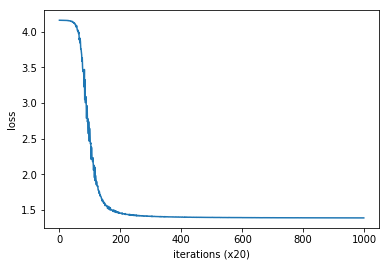

In [6]:
trainer.plot()

In [7]:
word_vecs = skip_gram.word_vecs
for word_id, word in idx2word.items():
    print(word, word_vecs[word_id])

language [-0.21309431  1.6804653   0.4939041   2.4694967  -0.6296761 ]
i [ 0.00138638  0.01094033 -0.00330304 -0.00310294 -0.00369503]
am [ 1.8094857  -0.12537725 -1.3987309  -1.2890778  -1.0422776 ]
now [1.3820957  1.1371192  2.1949883  0.3021466  0.06035005]
studying [-2.310864    1.1903393  -0.895635    0.38352096 -0.55852973]
processing [-1.2596842 -1.9213911  0.7302201 -0.6160461  1.3938596]
. [-0.02057644  0.00416552 -0.00790934 -0.00799866  0.00037165]
natural [ 0.7235034  -2.160613   -1.816959   -0.07483927  0.92904973]
